prompt:  load the parquet fies we created in the other two notebooks and perform
a regression to analyze the relationship between median income of a tract
(independent variable ) and the average download speeds (dependent variable ) in
that tract. You will need to do a spatial join on the two dataset, to locate
each point from the uss_mobile_2022q1 dataset to a census tract, then aggregate
by tract, computing the average or median download speed or upload speed. You
should create an analysis function to parameterize which statistic of central
tendencay we use, and which dependent variable we use. Use statsmodel for the OLS. 

## Updates

[ When you have completed an update, put `[DONE]` in front of it, after the bullet. ]

* [DONE] You do not need to create Points from tile_x and til_y in the uss_mobile dataset, there is already a geometry field. You might have to use shapely.loads to convert that from a string to a geometry, but check first.

* [DONE] Aggregating the joined dataset:  average these fields: ['avg_d_kbps',
  'avg_u_kbps', 'avg_lat_ms', 'avg_lat_down_ms', 'avg_lat_up_ms']. sum these
  fields: ['tests', 'devices']. group by: 'GEOID'. There should be only one
  'median_income', and it should be passed through. 



In [2]:
 # Enable autoreload and import libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load configuration
data_dir = None
%run ../../config.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: /Users/eric/proj/scratch/WirelessIncome
Data directory: /Users/eric/proj/scratch/WirelessIncome/data


In [ ]:

# Paths to parquet files produced by other notebooks
mobile_path = data_dir/"uss_mobile_2022.parquet"
tracts_path = data_dir/"tracts_with_income_2022.parquet"

# Load datasets
mobile_gdf = gpd.read_parquet(mobile_path)
tracts_gdf = gpd.read_parquet(tracts_path)


type(mobile_gdf), type(tracts_gdf)

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

In [36]:
print(f"Mobile data rows: {len(mobile_gdf)}")
print(f"Tracts: {len(tracts_gdf)}")

# Reproject to a common CRS for spatial operations
mobile_gdf = mobile_gdf.to_crs(epsg=3857)
tracts_gdf = tracts_gdf.to_crs(epsg=3857)

# Spatial join: assign each speed point to a tract
joined = gpd.sjoin(
    mobile_gdf,
    tracts_gdf[["GEOID", "median_income", "geometry"]],
    how="inner",
    predicate="within",
)

print(f"Joined rows: {len(joined)}")
joined.head()

Mobile data rows: 4066168
Tracts: 83225
Joined rows: 2473948


,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,ookla_year,ookla_quarter,ookla_service_type,geometry,index_right,GEOID,median_income
6301,1174,391,21,NaN,NaN,1,1,2022,1,mobile,POINT (-13700267.843 6272418.368),81316,53073011000,74400.0
7613,79001,10337,58,NaN,NaN,9,1,2022,1,mobile,POINT (-13697206.557 6273029.059),81316,53073011000,74400.0
7655,82789,9935,41,NaN,NaN,2,1,2022,1,mobile,POINT (-13664801.453 6274250.571),5161,53073010409,75239.0
7656,267211,50343,28,NaN,NaN,2,2,2022,1,mobile,POINT (-13664189.196 6274861.394),5161,53073010409,75239.0
7657,144491,16647,26,NaN,NaN,1,1,2022,1,mobile,POINT (-13667250.482 6273029.059),14650,53073010405,95288.0


In [41]:
joined[joined.GEOID == "53073011000"]

,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,ookla_year,ookla_quarter,ookla_service_type,geometry,index_right,GEOID,median_income
6301,1174,391,21,NaN,NaN,1,1,2022,1,mobile,POINT (-13700267.843 6272418.368),81316,53073011000,74400.0
7613,79001,10337,58,NaN,NaN,9,1,2022,1,mobile,POINT (-13697206.557 6273029.059),81316,53073011000,74400.0
3828377,41534,903,137,NaN,NaN,1,1,2022,2,mobile,POINT (-13698431.072 6274861.394),81316,53073011000,74400.0
3828378,2138,98,50,NaN,NaN,1,1,2022,2,mobile,POINT (-13697818.814 6274250.571),81316,53073011000,74400.0
3828379,49605,4718,105,NaN,NaN,4,2,2022,2,mobile,POINT (-13701492.358 6272418.368),81316,53073011000,74400.0
3828380,4181,25,69,NaN,NaN,1,1,2022,2,mobile,POINT (-13699655.586 6272418.368),81316,53073011000,74400.0
3828381,13911,421,31,NaN,NaN,1,1,2022,2,mobile,POINT (-13697818.814 6272418.368),81316,53073011000,74400.0
3828383,10288,1066,30,NaN,NaN,1,1,2022,2,mobile,POINT (-13701492.358 6270586.562),81316,53073011000,74400.0
3829785,65729,44679,28,NaN,NaN,6,1,2022,2,mobile,POINT (-13697206.557 6273639.793),81316,53073011000,74400.0
3829786,62659,7333,28,NaN,NaN,17,1,2022,2,mobile,POINT (-13697206.557 6273029.059),81316,53073011000,74400.0


In [4]:
# Aggregation function and OLS helper
import numpy as np

def aggregate_speeds(joined_gdf, by="GEOID", var="avg_d_kbps", stat="mean"):
    """
    Aggregate speeds by tract with chosen statistic.
    stat: 'mean' | 'median'
    var: column in joined_gdf for dependent variable (e.g., 'avg_d_kbps', 'avg_u_kbps')
    
    Aggregates:
    - Average: avg_d_kbps, avg_u_kbps, avg_lat_ms, avg_lat_down_ms, avg_lat_up_ms
    - Sum: tests, devices
    - Pass through: median_income
    """
    agg_dict = {
        'avg_d_kbps': stat,
        'avg_u_kbps': stat,
        'avg_lat_ms': stat,
        'avg_lat_down_ms': stat,
        'avg_lat_up_ms': stat,
        'tests': 'sum',
        'devices': 'sum',
        'median_income': 'first'
    }
    
    return joined_gdf.groupby(by).agg(agg_dict).reset_index()
    
# Example: aggregate using mean download speed and run OLS
agg_df = aggregate_speeds(joined, var="avg_d_kbps", stat="mean")


In [43]:
agg_df.head()

,GEOID,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,median_income
0,01001020100,76925.869565,6738.391304,44.565217,976.900000,1227.500000,35,29,60563.0
1,01001020200,42598.933333,11000.466667,69.200000,776.142857,1896.285714,25,17,57460.0
2,01001020300,122265.500000,19900.909091,34.545455,774.875000,678.500000,67,31,77371.0
3,01001020400,102976.833333,12908.055556,34.111111,934.200000,891.800000,40,26,73191.0
4,01001020501,96890.684211,15907.368421,28.105263,572.700000,717.600000,60,29,79953.0


In [22]:
agg_df.tests.describe() # hist(bins=50)

count    82193.000000
mean       126.837748
std        200.771421
min          1.000000
25%         45.000000
50%         85.000000
75%        153.000000
max      18342.000000
Name: tests, dtype: float64

In [7]:
agg_df.avg_d_kbps.describe()

count    8.219300e+04
mean     1.287503e+05
std      9.536891e+04
min      4.000000e+00
25%      6.550464e+04
50%      1.090657e+05
75%      1.670276e+05
max      2.080275e+06
Name: avg_d_kbps, dtype: float64

<Axes: >

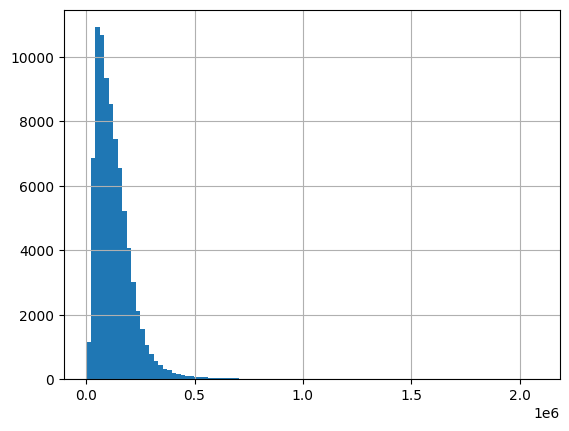

In [48]:
agg_df.avg_d_kbps.hist(bins=100)

<Axes: >

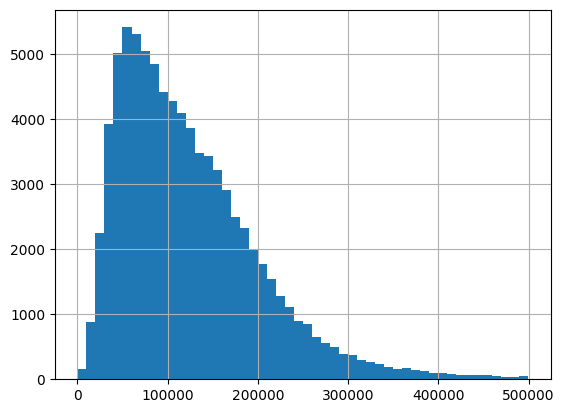

In [49]:
agg_df[agg_df.avg_d_kbps < 500_000].avg_d_kbps.hist(bins=50)

<Axes: >

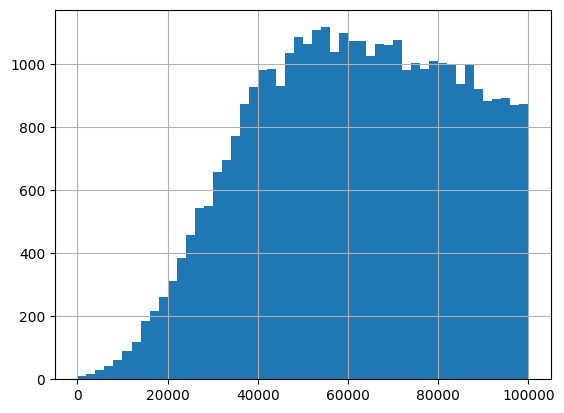

In [27]:


agg_df[agg_df.avg_d_kbps < 100_000].avg_d_kbps.hist(bins=50)

In [62]:
x = (agg_df.avg_d_kbps < 60_000).value_counts()
x[True]/len(agg_df)

np.float64(0.2145924835448274)

Looks like there is a a linear part below 40,000, so maybe just analyze that. 

<Axes: >

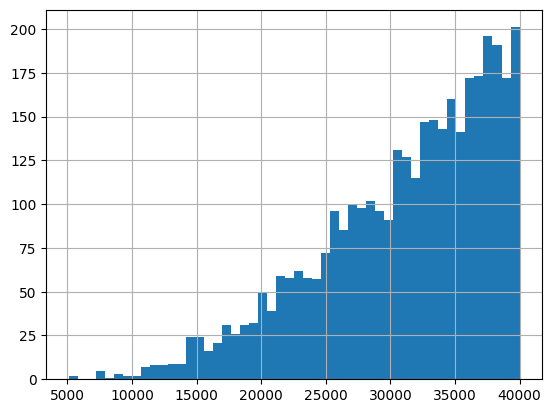

In [28]:
t = agg_df.copy()
t = t[t.tests > 50]

t = t[t.avg_d_kbps < 40000]

t.avg_d_kbps.hist(bins=50)

                            OLS Regression Results                            
Dep. Variable:             avg_d_kbps   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     26.71
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           2.49e-07
Time:                        16:52:25   Log-Likelihood:                -36851.
No. Observations:                3601   AIC:                         7.371e+04
Df Residuals:                    3599   BIC:                         7.372e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.957e+04    309.579     95.509

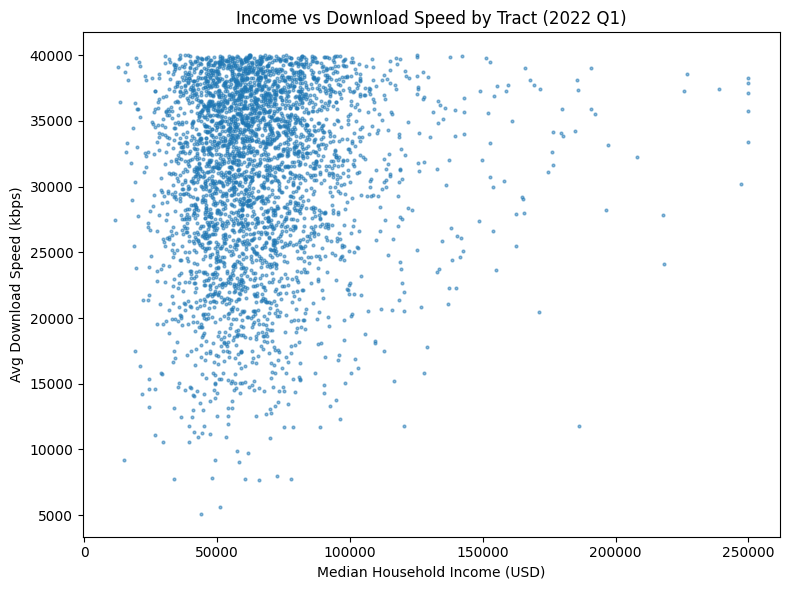

In [ ]:
x_var = "median_income"
y_var = "avg_d_kbps"

t = agg_df.copy()
t = t[t.tests > 50]

t = t[t.avg_d_kbps < 40000]


X = sm.add_constant(t[x_var])  # add intercept

y = t[y_var]

model = sm.OLS(y, X, missing="drop").fit()

print(model.summary())

# Quick scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(t[x_var], t[y_var], s=4, alpha=0.5)
ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income vs Download Speed by Tract (2022 Q1)")
plt.tight_layout()
plt.show()